In [1]:
import os
import datetime as dt

import pandas as pd
import numpy as np

from dask import dataframe as df1

import matplotlib.pyplot as plt
import seaborn as sns

import re


sns.set()

import warnings
warnings.filterwarnings('ignore')

# dask.set_options(get=dask.async.get_sync)
# from pyarrow import csv
# !pip install pandas pyarrow

In [38]:
import plotly.express as px

In [3]:
from jupyter_dash import JupyterDash

In [4]:
import dash
from dash import dcc
from dash import html

In [5]:
ny_listings = pd.read_csv("Data_Files/NewYork_Listings.csv")

In [6]:
ny_cal = pd.read_csv("Data_Files/calendar.csv.gz", compression="gzip",header=0, sep=",")

In [7]:
# '''
# Please note that this is a large file.  While it may work on one computer it may run into
# problems on others.  There are several work arounds that include pyarrow, dask, chunking, and page file management.
# I opted for the page file management as the other options would leave us with a sparse dataframe.
# <insert instructions here>
# '''
# ny_cal = df1.read_csv("Data_files/calendar.csv")

### EDA on Airbnb calendar data for NYC

In [8]:
ny_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2595,2022-06-04,f,$225.00,$225.00,30.0,1125.0
1,2595,2022-06-05,f,$225.00,$225.00,30.0,1125.0
2,2595,2022-06-06,f,$225.00,$225.00,30.0,1125.0
3,2595,2022-06-07,f,$225.00,$225.00,30.0,1125.0
4,2595,2022-06-08,f,$225.00,$225.00,30.0,1125.0


In [9]:
ny_cal.shape

(13649178, 7)

In [10]:
ny_cal.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [11]:
ny_cal.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

In [12]:
ny_cal.describe().drop("listing_id", axis=1)

,minimum_nights,maximum_nights
count,1.364882e+07,1.364882e+07
mean,2.698060e+01,2.322437e+06
std,7.819838e+01,7.055527e+07
min,1.000000e+00,1.000000e+00
25%,2.000000e+00,3.650000e+02
50%,3.000000e+01,1.125000e+03
75%,3.000000e+01,1.125000e+03
max,1.250000e+03,2.147484e+09


In [13]:
print("Unique listings in NYC:", len(ny_cal.listing_id.unique()))

Unique listings in NYC: 37395


#### Clean price column and summarize mean

In [14]:
# remove na in price column
ny_cal_cut = ny_cal[ny_cal.price.notna()]

# clean price column
new_price = [ p.replace("$", "").replace(",", "") for p in ny_cal_cut.price ]
ny_cal_cut.price = new_price
ny_cal_cut.price = round(ny_cal_cut.price.astype("float"), 2)

ny_cal_cut.price.describe().apply("{0:.4f}".format)

count    13649007.0000
mean          195.1919
std           375.8150
min             0.0000
25%            78.0000
50%           125.0000
75%           204.0000
max         48800.0000
Name: price, dtype: object

In [15]:
# summarize price by mean price by listing
ny_mean_price = ny_cal_cut.groupby("listing_id")["price"].mean().reset_index(name="mean")

ny_mean_price

,listing_id,mean
0,2595,213.495890
1,5121,60.000000
2,5136,275.000000
3,5178,68.147945
4,5203,78.635616
...,...,...
37390,640612171111039003,180.000000
37391,640629990855220048,620.000000
37392,640658348674867448,92.589041
37393,641072234133563797,528.616438


#### Cast date column to datetime type & visualize prices by day

In [16]:
# cast to date
ny_cal_cut['date'] = pd.to_datetime(ny_cal_cut['date'])

In [17]:
# summarize mean price
ny_price_day = ny_cal_cut.groupby("date")["price"].mean().reset_index(name="mean_price")

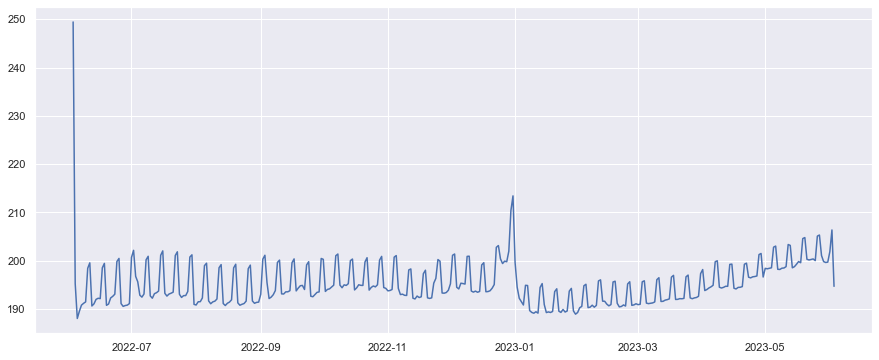

In [18]:
# visualize mean price by day
plt.figure(figsize=(15,6))
plt.plot(ny_price_day.date, ny_price_day.mean_price)
plt.show()

#### Model Selection

In [19]:
from sklearn.model_selection import train_test_split

def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=9, stratify=data['date'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=9, stratify=test_and_validate['date'])
    return train, validate, test

In [20]:
# x value will be prices
data = ny_cal_cut[["date", "price"]]

data['date'] = data['date'].map(dt.datetime.toordinal)

train, validate, test = split_data(data)
print("Train data size: ", train['date'].size)
print("Test data size: ", test['date'].size)
print("Validate data size: ", validate['date'].size)

Train data size:  10919205
Test data size:  1364901
Validate data size:  1364901


In [21]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [22]:
X_train = train["date"].values.reshape(-1, 1)
y_train = train["price"].values.reshape(-1, 1)

reg.fit(X_train, y_train)

LinearRegression()

In [23]:
X_test = test["date"].values.reshape(-1, 1)
y_test = test["price"].values.reshape(-1, 1)

preds = reg.predict(X_test)

In [24]:
reg.score(y_test, preds)

-49097103.23858913

#### Arima/Rolling Average

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime  
from datetime import timedelta  

def arma_log_ret(ser, p, q, num_forecasts):
    df = ser.reset_index()
    start = df['date'].iloc[-1] + timedelta(days=1)  

    model = ARIMA(ser,order=(p,0,q)).fit()
    forecasts = model.predict(start = start, end = start + timedelta(days=num_forecasts-1))
    
    return forecasts


def calc_rolling_stats(ser, wd_size=7):
    rolling_mean = ser.rolling(wd_size, min_periods=1).mean().to_numpy()
    
    if wd_size == 1:
        rolling_std = ser.rolling(wd_size).std(ddof=0).to_numpy()
    else:
        rolling_std = ser.rolling(wd_size, min_periods=1).std(ddof=0).to_numpy()
    
    return rolling_mean, rolling_std
    
def calc_log_ret(ser):
    log_ret = np.log(ser) - np.log(ser.shift(1))
    
    log_ret.dropna(inplace=True)
    
    return log_ret

In [26]:
# summarize price by mean price by day
ny_mean_dailyprice = ny_cal_cut.groupby("date")["price"].mean().reset_index(name="mean_price")

ny_mean_dailyprice.mean_price = round(ny_mean_dailyprice.mean_price, 2)

In [27]:
rolling_mean, rolling_std = calc_rolling_stats(ny_mean_dailyprice, wd_size=7)

In [28]:
rolling_mean.shape

(366, 1)

In [29]:
rolling_std.shape

(366, 1)

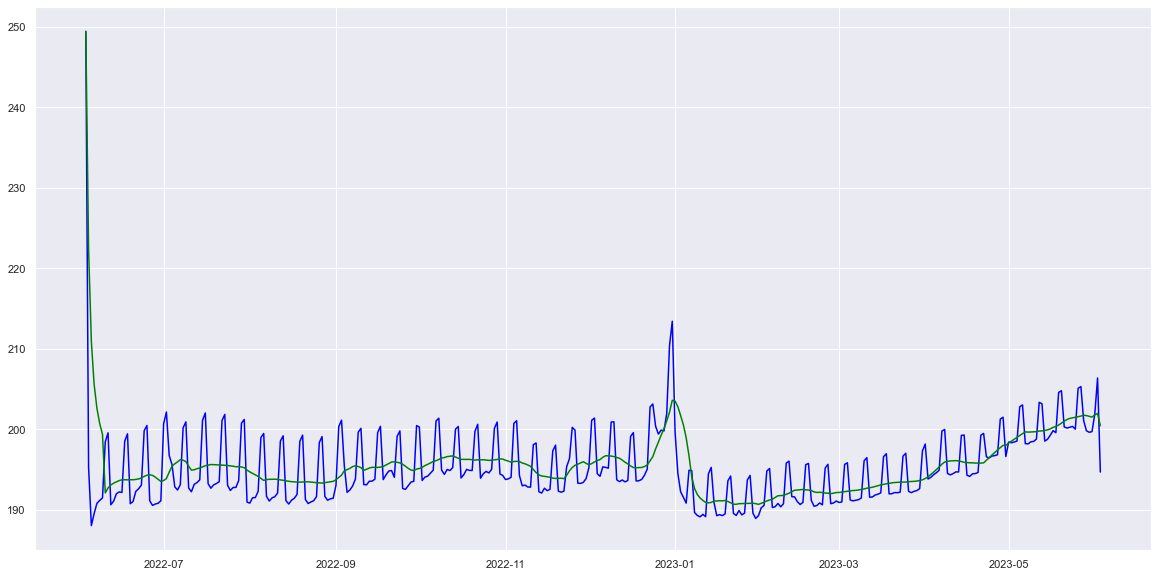

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(ny_mean_dailyprice.date, ny_mean_dailyprice.mean_price, color='blue')
ax.plot(ny_mean_dailyprice.date, pd.Series(rolling_mean.reshape(366,)), color='green')
# ax.plot(ny_mean_dailyprice.date, pd.Series(rolling_std.reshape(366,)), color='orange')

plt.show()

In [31]:
ny_mean_dailyprice = ny_cal_cut.groupby("date")["price"].mean().reset_index(name="mean_price")

ny_mean_dailyprice.mean_price = round(ny_mean_dailyprice.mean_price, 2)

ser = ny_mean_dailyprice
p=1
q=1
num_forecasts=365

df = ser.reset_index()
# start = df['date'].iloc[-1] + timedelta(days=1) 

# ser.index = pd.to_datetime(ser.date)
# ser = ser.resample("M").last()

start = df['date'].iloc[-1] + timedelta(days=1) 

df = ser.set_index("date")

end = start + timedelta(days=364)
model = ARIMA(df,order=(p,0,q), freq='D').fit()

forecasts = model.predict(start = start, end = end)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


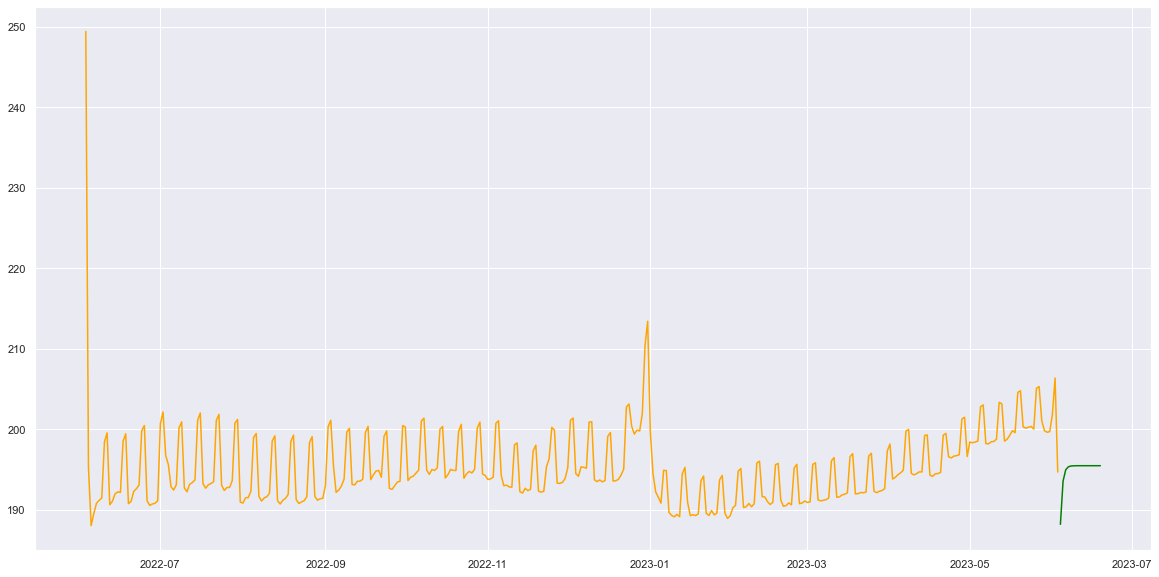

In [32]:
forecast_df = forecasts.reset_index()
forecast_df = forecast_df.rename(columns={'index':'date'})
forecast_df = forecast_df.loc[:15, :]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(ny_mean_dailyprice.date, ny_mean_dailyprice.mean_price, label="Original", color='orange')
ax.plot(forecast_df.date, forecast_df.predicted_mean, label="Forecasted", color='green')

plt.show()

In [33]:
forecast_df.head()

,date,predicted_mean
0,2023-06-04,188.217857
1,2023-06-05,193.584534
2,2023-06-06,194.995224
3,2023-06-07,195.366039
4,2023-06-08,195.463512


In [35]:
JupyterDash.infer_jupyter_proxy_config()

In [36]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

In [39]:
server = app.server

fig = px.scatter(forecast_df, x='date',y='predicted_mean')
app.layout = html.Div(children=[
    html.H1(children='Hello Dash'),

    html.Div(children='''
        Dash: A web application framework for your data.
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig
    )
])

In [40]:
app.run_server(mode="inline")